In [33]:
"""
FOR SCHWINGER
- Build all physical state with fixed field at boundary
- Generate the String state
- Time evolve
- Plot E(t)
"""

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [217]:
# same as graphAlgo.ipynb

def recursion(j,Nprec, Bs, Nlevel, states,N=5.,Ninit=0,periodic = False):   #generate physical state
    Bnew = 0
    Nnew = Nprec
    Bsnext = Bs.copy()
    Bsnext.append(Bnew)
    if j == N-1:
        if periodic:
            if Nnew == Ninit:
                states.append(Bsnext)
        else:
            states.append(Bsnext)

    else:
        recursion(j+1,Nnew,Bsnext,Nlevel,states,N,Ninit,periodic)

    Bnew = 1
    Nnew = Nprec + (-1)**j
    if Nnew >= 0 and Nnew <=Nlevel:
        Bsnext = Bs.copy()
        Bsnext.append(Bnew)
        if j == N-1:
            if periodic:
                if Nnew == Ninit:
                    states.append(Bsnext)
            else:
                states.append(Bsnext)
        else:
            recursion(j+1,Nnew,Bsnext,Nlevel,states,N,Ninit,periodic)


def getField(Sinit,state):          
    field = np.zeros(len(state)+1)
    field[0] = Sinit
    Scurrent = Sinit
    for i,x in enumerate(state):
        Snext = Scurrent + (-1)**i * x
        field[i+1] = Snext
        Scurrent = Snext
    return field

def getAllFields(Sinit,states):
    fields = np.zeros((len(states),len(states[0])+1))
    for i, state in enumerate(states):
        fields[i] = getField(Sinit, state)
    return fields


def stateToFermion(state):
    N = len(state)
    x = np.arange(N)%2
    return (state+x) %2


def statesToFermions(states):
    dim = len(states)
    N = len(states[0])
    x = np.repeat( [np.arange(N)%2], dim, axis=0)
    return((states+x) %2)




def findField(fields,f):
    dim = len(fields)
    index =[]
    for i in range(dim):
        if np.allclose(fields[i],f):
            index.append(i)
    if len(index) == 1:
        return index[0]
    print("mh problem find fields")
    return index

def createHamiltonian(fermionsStates,spinsStates, t = 1 , m = 0.2 , g = 1):

    dim = len(fermionsStates)
    N = len(fermionsStates[0])

    x = (-2 * (np.arange(N)%2) +1)

    df = -2**0.5 * t
    H = np.zeros((dim,dim))
    for i in tqdm(range(dim)):
        H[i,i] += 0.5* (g**2) * np.sum(spinsStates[i]**2)
        H[i,i] += m * np.sum(fermionsStates[i]*x)

        H[i,i] += df * np.sum(fermionsStates[i])
        H[i,i] += - df * fermionsStates[i,0]
        H[i,i] += - df * fermionsStates[i]@  np.diag(np.ones(N-1),k=1)  @fermionsStates[i]
        
        for n in range(N-1):
            y = np.zeros(N)
            y[n] = -1
            y[n+1] = 1
            if np.sum(y * fermionsStates[i]) == 1 and spinsStates[i][n+1] <=S-1:
                f = spinsStates[i].copy()
                f[n+1] += 1 
                j = findField(spinsStates,f)
                H[j,i] += -t
                H[i,j] += -t
    return(H)

def E(state,fields):
    return np.einsum('i,in->n', np.absolute(state)**2, fields)

def configString(dim):      #String 
    v = np.zeros(dim)
    v[0] = 1
    return v



In [221]:
S = 1
Sinit=-1

N = 10
states=[]

Nlevel = int(2*S)
Ninit = Sinit + S

#Generate the basis for Hphys
recursion(0,Ninit,[],Nlevel,states,N,Ninit, True)
states = np.array(states)


fields = getAllFields(Sinit,states)
fermions = statesToFermions(states)
print(fermions.shape)
print(fields)

(131, 10)
[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1.  0. -1.]
 [-1. -1. -1. ...  0.  0. -1.]
 ...
 [-1.  0. -1. ...  0.  0. -1.]
 [-1.  0. -1. ... -1. -1. -1.]
 [-1.  0. -1. ... -1.  0. -1.]]


In [222]:
t = 1
g = (t * 2**0.5 )**0.5
m = -0.

H = createHamiltonian(fermions, fields,t,m,g)

  0%|          | 0/131 [00:00<?, ?it/s]

100%|██████████| 131/131 [00:01<00:00, 90.44it/s] 


In [223]:
Energie,P = np.linalg.eigh(H)


In [224]:
#TIME EVOLUTION OF THE STRING

state0 = configString(len(fermions))
Tf = 30
ns = 401
T = np.linspace(0,Tf,ns)


Efields =  np.zeros((ns,N+1))
Efields[0] = E(state0,fields)

B = np.transpose(P)@state0

for i,f in tqdm(enumerate(T[1:])):
    state = P @ (np.exp(-1j*f*Energie) * B)
    Efields[i+1] = E(state,fields)

400it [00:00, 3227.41it/s]


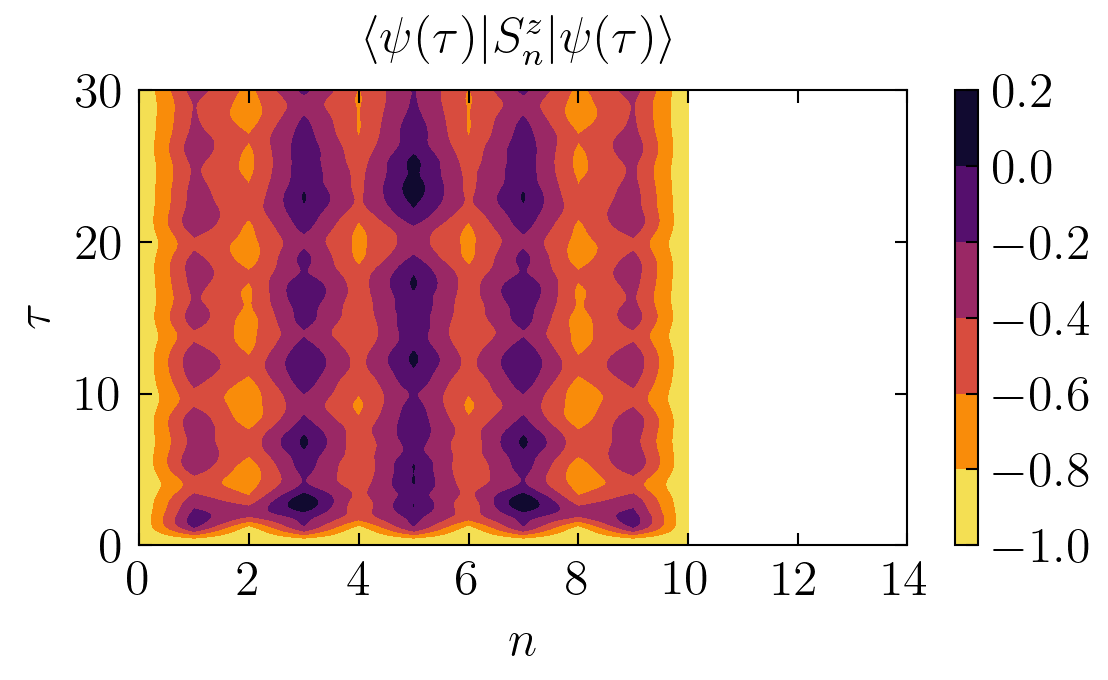

In [225]:
pos,time = np.meshgrid(np.arange(N+1), T)


plt.style.use(["science"])
color = ["#0072BD", "#D95319", "#EDB120", "#7E2F8E", "#77AC30", "#4DBEEE", "#A2142F"]

cm = 1 / 2.54
maxsize = 5.9

fig,ax=plt.subplots(1,1, figsize=(0.7*maxsize, 5 * cm),dpi=300)
cp = ax.contourf(pos,time,Efields,6,cmap="inferno_r")


cb = fig.colorbar(cp) # Add a colorbar to a plot
plt.title(r"$\langle\psi(\tau)|S^z_n|\psi(\tau)\rangle$",fontsize=12,y = 1.03)
ax.set_xlabel(r'$n$')
ax.set_ylabel(r'$\tau$')
plt.xticks(np.arange(0,15)[::2])
plt.rcParams["font.size"] = "12"
plt.minorticks_off()
#plt.savefig("IMG/SnvsT.png", bbox_inches="tight")
plt.show()


-3.0504081587257668


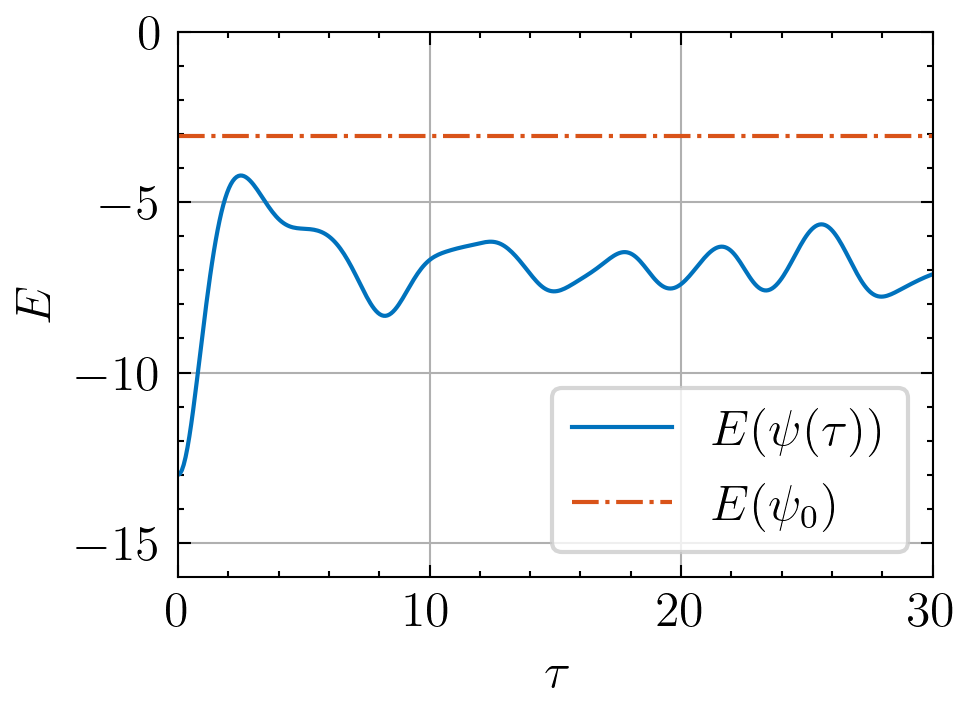

In [216]:
Eend = np.sum(E(P[:,0],fields))

print(Eend)

Eg = np.sum(Efields,axis=1)




plt.style.use(["science"])
color = ["#0072BD", "#D95319", "#EDB120", "#7E2F8E", "#77AC30", "#4DBEEE", "#A2142F"]

cm = 1 / 2.54
maxsize = 5.9

fig= plt.figure(figsize=(0.55*maxsize, 6 * cm), dpi=300)
ax=plt.gca()    


plt.plot(T,Eg,color=color[0],label=r"$E(\psi(\tau))$")
plt.plot([0,Tf],[Eend,Eend],'-.',color=color[1],label=r"$E(\psi_0)$")

ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$E$')
#plt.xticks(np.arange(0,15)[::2])
ax.set_xlim([0,30])
ax.set_ylim([-16,0])
plt.rcParams["font.size"] = "12"
plt.grid()
plt.legend(frameon=True,loc="lower right")
#plt.savefig("IMG/EvsT.png", bbox_inches="tight")

plt.show()
